In [30]:
import os
import pandas as pd

In [31]:
eth = f'/Users/gabrielefabietti/projects/fetch_data/data/data4/ETHUSDT_5_data.csv'
btc = f'/Users/gabrielefabietti/projects/fetch_data/data/data4/BTCUSDT_5_data.csv'
sol = f'/Users/gabrielefabietti/projects/fetch_data/data/data4/SOLUSDT_5_data.csv'

df_eth = pd.read_csv(eth)
df_btc = pd.read_csv(btc)
df_sol = pd.read_csv(sol)

In [32]:
df_sol = df_sol.drop('Unnamed: 0', axis=1)

In [33]:
df_sol.head()

,timestamp,open,high,low,close,volume,turnover
0,1704063600000,100.657,101.317,100.452,101.103,37522.8,3.786878e+06
1,1704063900000,101.103,101.822,101.000,101.725,47695.3,4.838085e+06
2,1704064200000,101.725,101.773,100.975,100.996,45371.0,4.604492e+06
3,1704064500000,100.996,101.207,100.161,100.357,72599.3,7.308087e+06
4,1704064800000,100.357,100.653,99.800,100.483,57223.0,5.733507e+06


In [34]:
df_eth['pct_change_eth'] = (df_eth['close'] - df_eth['open']) / df_eth['open'] * 100

In [35]:
df_btc['pct_change_btc'] = (df_btc['close'] - df_btc['open']) / df_btc['open'] * 100
df_sol['pct_change_sol'] = (df_sol['close'] - df_sol['open']) / df_sol['open'] * 100

In [36]:
df_btc = df_btc.set_index('timestamp')
df_eth = df_eth.set_index('timestamp')
df_sol = df_sol.set_index('timestamp')

In [37]:
combined_df = df_btc['close'].to_frame(name='btc_close')
combined_df = combined_df.join(df_eth['close'].rename('eth_close'))
combined_df = combined_df.join(df_sol['close'].rename('sol_close'))

combined_df.head()

,btc_close,eth_close,sol_close
timestamp,,,
1704063600000,42329.1,2282.75,101.103
1704063900000,42342.4,2284.87,101.725
1704064200000,42273.1,2282.57,100.996
1704064500000,42192.0,2279.09,100.357
1704064800000,42171.3,2278.11,100.483


In [38]:
combined_df = combined_df.join(df_btc['pct_change_btc'])
combined_df = combined_df.join(df_sol['pct_change_sol'])
combined_df = combined_df.join(df_eth['pct_change_eth'])

combined_df.head()

,btc_close,eth_close,sol_close,pct_change_btc,pct_change_sol,pct_change_eth
timestamp,,,,,,
1704063600000,42329.1,2282.75,101.103,0.067138,0.443089,0.307150
1704063900000,42342.4,2284.87,101.725,0.031420,0.615214,0.092870
1704064200000,42273.1,2282.57,100.996,-0.163666,-0.716638,-0.100662
1704064500000,42192.0,2279.09,100.357,-0.191848,-0.632698,-0.152460
1704064800000,42171.3,2278.11,100.483,-0.049061,0.125552,-0.043000


In [39]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134317 entries, 1704063600000 to 1744358400000
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   btc_close       134317 non-null  float64
 1   eth_close       134316 non-null  float64
 2   sol_close       134314 non-null  float64
 3   pct_change_btc  134317 non-null  float64
 4   pct_change_sol  134314 non-null  float64
 5   pct_change_eth  134316 non-null  float64
dtypes: float64(6)
memory usage: 7.2 MB


Final Portfolio:
cash: 11036.37
btc: 0.00
sol: 0.07
eth: 0.00
final_value: nan

Performance Metrics:
Initial Investment: 10000.00
Final Value: nan
Total Return (%): nan
Volatility (%): 0.01
Sharpe Ratio: 0.11


/var/folders/96/c9w5p21d6f75kc8hs0t3wfhc0000gn/T/ipykernel_15118/1562513835.py:153: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = history['total_value'].pct_change().dropna()


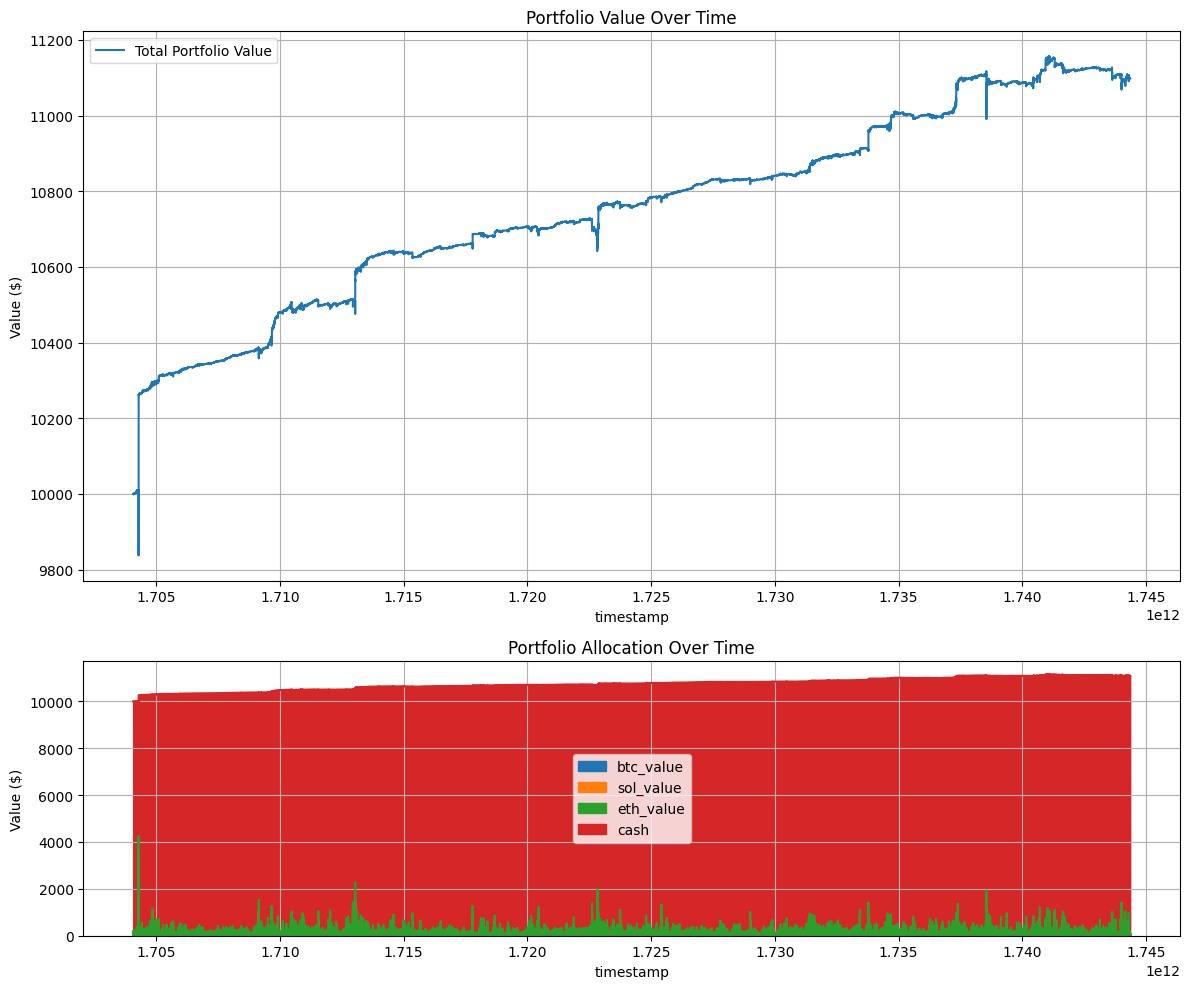

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class CryptoStrategyTester:
    def __init__(self, df, buy_threshold=0.1, sell_threshold=0.1, initial_cash=10000, initial_holdings=0):
        """
        Initialize the strategy tester with parameters
        
        Parameters:
        -----------
        df : pandas DataFrame
            DataFrame containing crypto price data and percentage changes
        buy_threshold : float
            Percentage threshold to trigger buy orders (positive number)
        sell_threshold : float
            Percentage threshold to trigger sell orders (positive number)
        initial_cash : float
            Initial cash in the portfolio
        initial_holdings : float
            Initial holdings of each asset
        """
        self.df = df.copy()
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold
        self.initial_cash = initial_cash
        self.initial_holdings = initial_holdings
        
        # Ensure timestamp is set as index if not already
        if 'timestamp' in self.df.columns:
            self.df = self.df.set_index('timestamp')
        
        # Make sure percentage columns have correct names
        self.pct_columns = [col for col in self.df.columns if 'pct_change' in col]
        self.assets = [col.replace('pct_change_', '') for col in self.pct_columns]
        self.price_columns = [f"{asset}_close" for asset in self.assets]
        
        # Validate that all necessary columns exist
        for col in self.pct_columns + self.price_columns:
            if col not in self.df.columns:
                raise ValueError(f"Column {col} not found in DataFrame")
    
    def run_simulation(self):
        """Run the trading simulation and return the results"""
        # Initialize portfolio
        portfolio = {
            'cash': self.initial_cash,
            **{asset: self.initial_holdings for asset in self.assets},
            'history': []
        }
        
        # Iterate through each timestamp
        for idx, row in self.df.iterrows():
            # Execute trades for each asset
            for asset in self.assets:
                pct_change_col = f"pct_change_{asset}"
                price_col = f"{asset}_close"
                
                pct_change = row[pct_change_col]
                price = row[price_col]
                
                if pct_change <= -self.buy_threshold:
                    # Buy asset if it dropped by threshold or more
                    amount_to_buy = abs(pct_change)  # Buy percentage amount
                    cash_to_spend = amount_to_buy *100
                    # Ensure we don't spend more than we have
                    cash_to_spend = min(cash_to_spend, portfolio['cash'])
                    asset_bought = cash_to_spend / price
                    
                    portfolio['cash'] -= cash_to_spend
                    portfolio[asset] += asset_bought
                    
                elif pct_change >= self.sell_threshold:
                    # Sell asset if it rose by threshold or more
                    amount_to_sell = abs(pct_change)  # Sell percentage amount
                    asset_to_sell = amount_to_sell *100
                    # Ensure we don't sell more than we have
                    asset_to_sell = min(asset_to_sell, portfolio[asset])
                    cash_received = asset_to_sell * price
                    
                    portfolio[asset] -= asset_to_sell
                    portfolio['cash'] += cash_received
            
            # Calculate portfolio value
            portfolio_value = portfolio['cash']
            asset_values = {}
            
            for asset in self.assets:
                price_col = f"{asset}_close"
                asset_values[f"{asset}_value"] = portfolio[asset] * row[price_col]
                portfolio_value += asset_values[f"{asset}_value"]
            
            # Record portfolio state
            portfolio_state = {
                'timestamp': idx,
                'cash': portfolio['cash'],
                'total_value': portfolio_value,
                **{asset: portfolio[asset] for asset in self.assets},
                **asset_values
            }
            portfolio['history'].append(portfolio_state)
        
        # Create a history DataFrame
        history_df = pd.DataFrame(portfolio['history'])
        if 'timestamp' in history_df.columns:
            history_df = history_df.set_index('timestamp')
        
        return {
            'final_portfolio': {
                'cash': portfolio['cash'],
                **{asset: portfolio[asset] for asset in self.assets},
                'final_value': portfolio_value
            },
            'history': history_df
        }
    
    def plot_results(self, results):
        """Plot the results of the simulation"""
        history = results['history']
        
        # Create a figure with subplots
        fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot portfolio value
        history['total_value'].plot(ax=axes[0], label='Total Portfolio Value')
        axes[0].set_title('Portfolio Value Over Time')
        axes[0].set_ylabel('Value ($)')
        axes[0].grid(True)
        axes[0].legend()
        
        # Plot asset allocations
        asset_columns = [f"{asset}_value" for asset in self.assets]
        history[asset_columns + ['cash']].plot(ax=axes[1], kind='area', stacked=True)
        axes[1].set_title('Portfolio Allocation Over Time')
        axes[1].set_ylabel('Value ($)')
        axes[1].grid(True)
        
        plt.tight_layout()
        return fig
    
    def calculate_metrics(self, results):
        """Calculate performance metrics"""
        history = results['history']
        
        initial_value = self.initial_cash
        final_value = history['total_value'].iloc[-1]
        
        # Calculate returns
        total_return_pct = ((final_value / initial_value) - 1) * 100
        
        # Calculate daily returns if we have enough data
        if len(history) > 1:
            daily_returns = history['total_value'].pct_change().dropna()
            volatility = daily_returns.std() * 100
            sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() > 0 else 0
        else:
            volatility = 0
            sharpe_ratio = 0
        
        metrics = {
            'Initial Investment': initial_value,
            'Final Value': final_value,
            'Total Return (%)': total_return_pct,
            'Volatility (%)': volatility,
            'Sharpe Ratio': sharpe_ratio
        }
        
        return metrics

# Example usage
if __name__ == "__main__":
    
    # Run simulation
    tester = CryptoStrategyTester(
        combined_df, 
        buy_threshold=0.001,  # Buy if drops 0.1% or more
        sell_threshold=0.001,  # Sell if rises 0.1% or more
        initial_cash=10000,  # Start with $10,000
        initial_holdings=0   # Start with 0 units of each crypto
    )
    
    results = tester.run_simulation()
    
    # Print results
    print("Final Portfolio:")
    for key, value in results['final_portfolio'].items():
        print(f"{key}: {value:.2f}")
    
    # Calculate and print metrics
    metrics = tester.calculate_metrics(results)
    print("\nPerformance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")
    
    # Plot results
    fig = tester.plot_results(results)
    plt.show()

# Function to run a parameter sweep to find optimal thresholds
def parameter_sweep(df, buy_thresholds, sell_thresholds, initial_cash=10000):
    """
    Run simulations with different threshold combinations to find the optimal strategy
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing crypto price data and percentage changes
    buy_thresholds : list
        List of buy threshold values to test
    sell_thresholds : list
        List of sell threshold values to test
    initial_cash : float
        Initial cash in the portfolio
        
    Returns:
    --------
    results_df : pandas DataFrame
        DataFrame containing results for each parameter combination
    """
    results = []
    
    for buy_threshold in buy_thresholds:
        for sell_threshold in sell_thresholds:
            tester = CryptoStrategyTester(
                df, 
                buy_threshold=buy_threshold,
                sell_threshold=sell_threshold,
                initial_cash=initial_cash,
                initial_holdings=0
            )
            
            sim_results = tester.run_simulation()
            metrics = tester.calculate_metrics(sim_results)
            
            results.append({
                'buy_threshold': buy_threshold,
                'sell_threshold': sell_threshold,
                'final_value': metrics['Final Value'],
                'total_return': metrics['Total Return (%)'],
                'sharpe_ratio': metrics['Sharpe Ratio']
            })
    
    return pd.DataFrame(results)

/var/folders/96/c9w5p21d6f75kc8hs0t3wfhc0000gn/T/ipykernel_15118/2639803595.py:196: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = history['total_value'].pct_change().dropna()



Performance Metrics:
Initial Investment: 10000.00
Final Value: nan
Total Return (%): nan
Volatility (%): 0.01
Sharpe Ratio: 0.11
Total Trades: 399439.00
Buys: 198928.00
Sells: 200511.00
Trades by Asset:
  btc: 133055
  eth: 133484
  sol: 132900


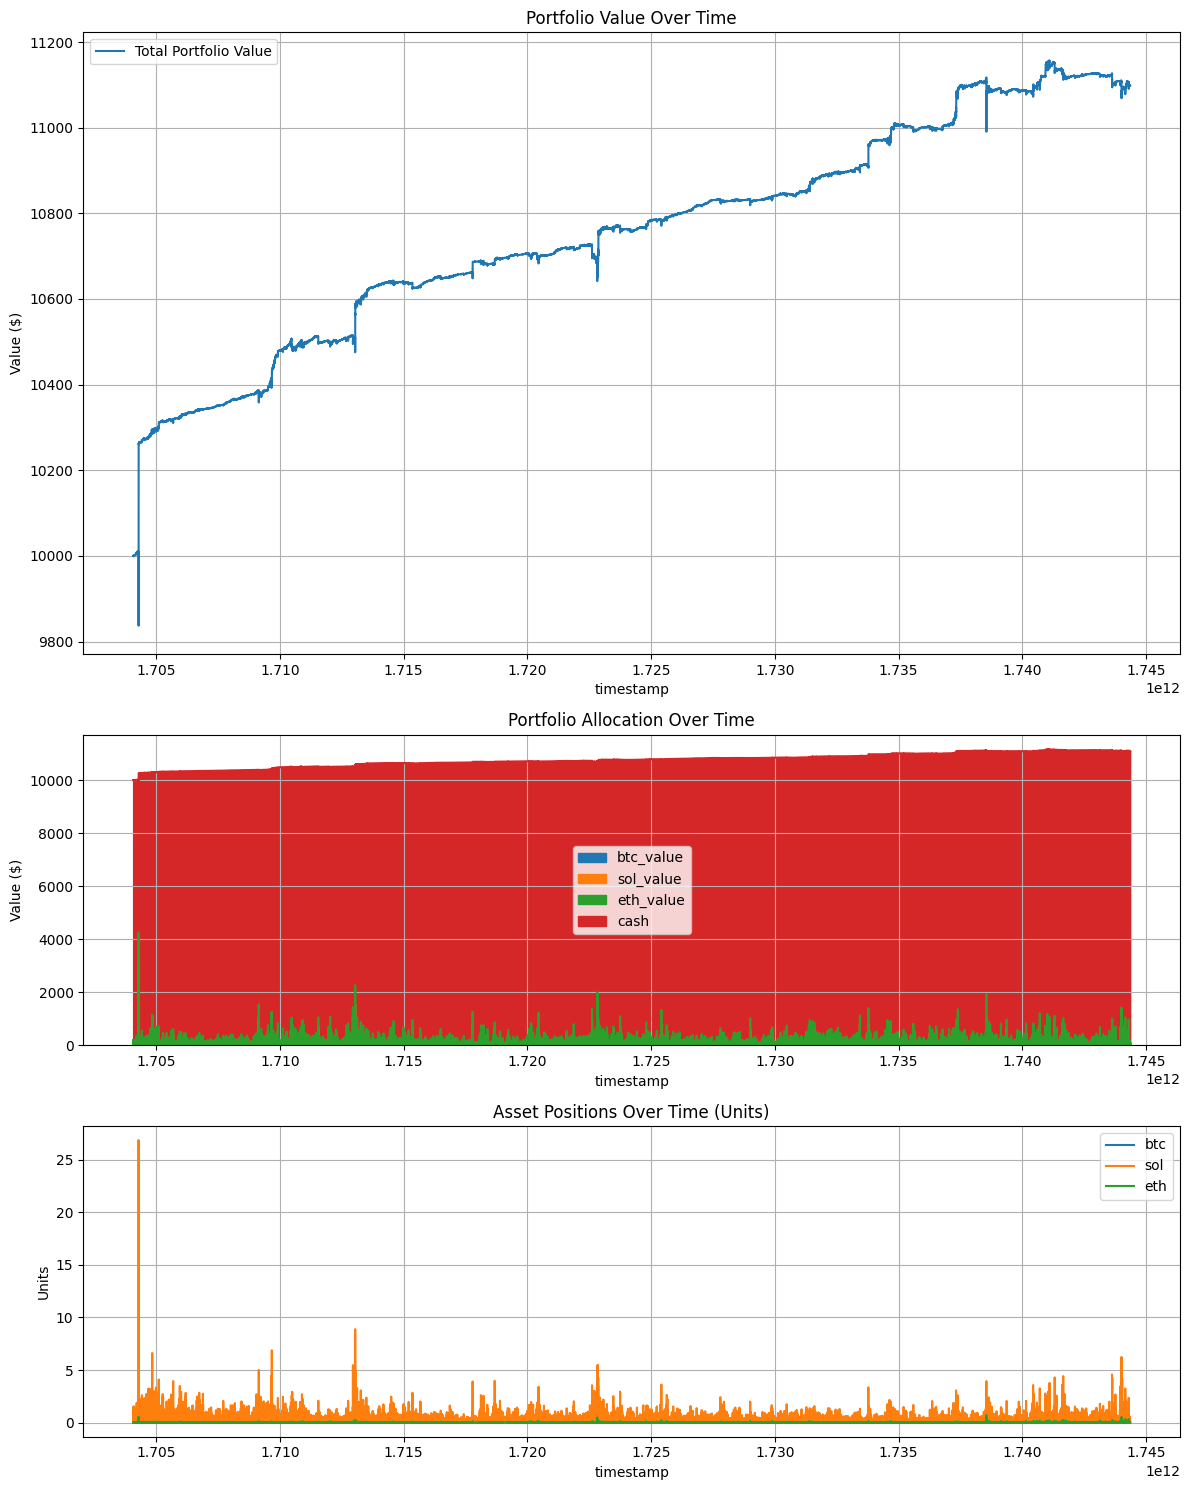

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class CryptoStrategyTester:
    def __init__(self, df, buy_threshold=0.1, sell_threshold=0.1, initial_cash=10000, initial_holdings=0):
        """
        Initialize the strategy tester with parameters
        
        Parameters:
        -----------
        df : pandas DataFrame
            DataFrame containing crypto price data and percentage changes
        buy_threshold : float
            Percentage threshold to trigger buy orders (positive number)
        sell_threshold : float
            Percentage threshold to trigger sell orders (positive number)
        initial_cash : float
            Initial cash in the portfolio
        initial_holdings : float
            Initial holdings of each asset
        """
        self.df = df.copy()
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold
        self.initial_cash = initial_cash
        self.initial_holdings = initial_holdings
        
        # Ensure timestamp is set as index if not already
        if 'timestamp' in self.df.columns:
            self.df = self.df.set_index('timestamp')
        
        # Make sure percentage columns have correct names
        self.pct_columns = [col for col in self.df.columns if 'pct_change' in col]
        self.assets = [col.replace('pct_change_', '') for col in self.pct_columns]
        self.price_columns = [f"{asset}_close" for asset in self.assets]
        
        # Validate that all necessary columns exist
        for col in self.pct_columns + self.price_columns:
            if col not in self.df.columns:
                raise ValueError(f"Column {col} not found in DataFrame")
    
    def run_simulation(self):
        """Run the trading simulation and return the results"""
        # Initialize portfolio
        portfolio = {
            'cash': self.initial_cash,
            **{asset: self.initial_holdings for asset in self.assets},
            'history': [],
            'trades': []
        }
        
        # Iterate through each timestamp
        for idx, row in self.df.iterrows():
            # Track the trades for this candle
            candle_trades = []
            
            # Execute trades for each asset
            for asset in self.assets:
                pct_change_col = f"pct_change_{asset}"
                price_col = f"{asset}_close"
                
                pct_change = row[pct_change_col]
                price = row[price_col]
                
                if pct_change <= -self.buy_threshold:
                    # Buy asset if it dropped by threshold or more
                    amount_to_buy = abs(pct_change)  # Buy percentage amount of portfolio
                    cash_to_spend = amount_to_buy * 100
                    # Ensure we don't spend more than we have
                    cash_to_spend = min(cash_to_spend, portfolio['cash'])
                    asset_bought = cash_to_spend / price
                    
                    portfolio['cash'] -= cash_to_spend
                    portfolio[asset] += asset_bought
                    
                    # Record trade
                    trade = {
                        'timestamp': idx,
                        'asset': asset,
                        'action': 'buy',
                        'amount': asset_bought,
                        'price': price,
                        'value': cash_to_spend
                    }
                    portfolio['trades'].append(trade)
                    candle_trades.append(f"Bought {asset_bought:.8f} {asset.upper()} for ${cash_to_spend:.2f}")
                    
                elif pct_change >= self.sell_threshold:
                    # Sell asset if it rose by threshold or more
                    amount_to_sell = abs(pct_change)  # Sell percentage amount of portfolio
                    asset_to_sell = amount_to_sell * 100
                    # Ensure we don't sell more than we have
                    asset_to_sell = min(asset_to_sell, portfolio[asset])
                    cash_received = asset_to_sell * price
                    
                    portfolio[asset] -= asset_to_sell
                    portfolio['cash'] += cash_received
                    
                    # Record trade
                    trade = {
                        'timestamp': idx,
                        'asset': asset,
                        'action': 'sell',
                        'amount': asset_to_sell,
                        'price': price,
                        'value': cash_received
                    }
                    portfolio['trades'].append(trade)
                    candle_trades.append(f"Sold {asset_to_sell:.8f} {asset.upper()} for ${cash_received:.2f}")
            
            # Calculate portfolio value
            portfolio_value = portfolio['cash']
            asset_values = {}
            
            for asset in self.assets:
                price_col = f"{asset}_close"
                asset_values[f"{asset}_value"] = portfolio[asset] * row[price_col]
                portfolio_value += asset_values[f"{asset}_value"]
            
            # Record portfolio state
            portfolio_state = {
                'timestamp': idx,
                'cash': portfolio['cash'],
                'total_value': portfolio_value,
                **{asset: portfolio[asset] for asset in self.assets},
                **asset_values,
                'actions': candle_trades
            }
            portfolio['history'].append(portfolio_state)
        
        # Create a history DataFrame
        history_df = pd.DataFrame(portfolio['history'])
        if 'timestamp' in history_df.columns:
            history_df = history_df.set_index('timestamp')
        
        # Create a trades DataFrame
        trades_df = pd.DataFrame(portfolio['trades'])
        if not trades_df.empty and 'timestamp' in trades_df.columns:
            trades_df = trades_df.set_index('timestamp')
        
        return {
            'final_portfolio': {
                'cash': portfolio['cash'],
                **{asset: portfolio[asset] for asset in self.assets},
                'final_value': portfolio_value
            },
            'history': history_df,
            'trades': trades_df
        }
    
    def plot_results(self, results):
        """Plot the results of the simulation"""
        history = results['history']
        
        # Create a figure with subplots
        fig, axes = plt.subplots(3, 1, figsize=(12, 15), gridspec_kw={'height_ratios': [2, 1, 1]})
        
        # Plot portfolio value
        history['total_value'].plot(ax=axes[0], label='Total Portfolio Value')
        axes[0].set_title('Portfolio Value Over Time')
        axes[0].set_ylabel('Value ($)')
        axes[0].grid(True)
        axes[0].legend()
        
        # Plot asset allocations
        asset_columns = [f"{asset}_value" for asset in self.assets]
        history[asset_columns + ['cash']].plot(ax=axes[1], kind='area', stacked=True)
        axes[1].set_title('Portfolio Allocation Over Time')
        axes[1].set_ylabel('Value ($)')
        axes[1].grid(True)
        
        # Plot asset positions (number of units)
        history[self.assets].plot(ax=axes[2])
        axes[2].set_title('Asset Positions Over Time (Units)')
        axes[2].set_ylabel('Units')
        axes[2].grid(True)
        axes[2].legend()
        
        plt.tight_layout()
        return fig
    
    def calculate_metrics(self, results):
        """Calculate performance metrics"""
        history = results['history']
        trades = results['trades']
        
        initial_value = self.initial_cash
        final_value = history['total_value'].iloc[-1]
        
        # Calculate returns
        total_return_pct = ((final_value / initial_value) - 1) * 100
        
        # Calculate daily returns if we have enough data
        if len(history) > 1:
            daily_returns = history['total_value'].pct_change().dropna()
            volatility = daily_returns.std() * 100
            sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() > 0 else 0
        else:
            volatility = 0
            sharpe_ratio = 0
        
        # Calculate trade statistics
        if not trades.empty:
            total_trades = len(trades)
            buys = len(trades[trades['action'] == 'buy'])
            sells = len(trades[trades['action'] == 'sell'])
            
            # Calculate trades by asset
            trades_by_asset = trades.groupby('asset').size().to_dict()
        else:
            total_trades = 0
            buys = 0
            sells = 0
            trades_by_asset = {asset: 0 for asset in self.assets}
        
        metrics = {
            'Initial Investment': initial_value,
            'Final Value': final_value,
            'Total Return (%)': total_return_pct,
            'Volatility (%)': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Total Trades': total_trades,
            'Buys': buys,
            'Sells': sells,
            'Trades by Asset': trades_by_asset
        }
        
        return metrics

# Example usage
if __name__ == "__main__":
    
    # Run simulation
    tester = CryptoStrategyTester(
        combined_df, 
        buy_threshold=0.001,  # Buy if drops 0.1% or more
        sell_threshold=0.001,  # Sell if rises 0.1% or more
        initial_cash=10000,  # Start with $10,000
        initial_holdings=0   # Start with 0 units of each crypto
    )
    
    results = tester.run_simulation()
    
    # Calculate and print metrics
    metrics = tester.calculate_metrics(results)
    print("\nPerformance Metrics:")
    for key, value in metrics.items():
        if isinstance(value, dict):
            print(f"{key}:")
            for k, v in value.items():
                print(f"  {k}: {v}")
        else:
            print(f"{key}: {value:.2f}")
    
    # Plot results
    fig = tester.plot_results(results)
    plt.show()